## Evolution of Concepts by Data and Text Mining from Scholarly Literature

### Loading modules

In [6]:
import pandas as pd
import json
import requests
from wordcloud import WordCloud, STOPWORDS
from datetime import date
import pymc
import numpy as np
import sys, string

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from statsmodels.tsa.arima_model import ARMA

In [5]:
import warnings
warnings.filterwarnings('ignore')

### Initial Functions 

In [25]:
def make_url(query, offset, rows, since):
    """a funtion to make the api url"""
        
    url = 'https://api.crossref.org/works?query.title={}&rows={}'.format(query,rows)
    url +='&offset={}'.format(offset)
    url +='&filter=from-pub-date:{}'.format(since)
    return url

In [26]:
def update_dicts(api_content, auth_nums, auth_cits, year_nums, year_text):
    """
    a function to extract data from each api query 
       and update them to dictionaries
    """
    
    for item in api_content:
        try:
            item['author']
            for author in item['author']:
                name = author['given'].title() + ' ' + author['family'].title()
                auth_nums[name] = auth_nums.get(name,0) + 1
                auth_cits[name] = auth_cits.get(name,0) + item['reference-count']
        except:
            pass
        
        year = item['issued'].values()[0][0][0]        
        year_text[year] = year_text.get(year, '') + ' ' + item['title'][0]
        year_nums[year] = year_nums.get(year, 0) + 1

    return auth_nums, auth_cits, year_nums, year_text

In [27]:
def add_stopwords(query):
    add_stop = query.lower().split() +\
        ['using', 'based', '-based', 'system', 'systems', 'study', 'studies', 'analysis']
    
    for p in ':,"?':
        for w in query.lower().split():
            add_stop.append(w+p)
    return add_stop

### Conversion to DataFrame

In [28]:
def make_df(dic):
    dic_df = pd.DataFrame( dic.values(), dic.keys())
    dic_df.columns = ['counts']
    return dic_df

### Initial Author Graphs

In [29]:
def plot_authors(nums_df, cits_df, howmany=-9,w=15.0, h=4.6):
    """ a funtion to plot top authors"""
        
    fig = plt.subplots(figsize=(w,h))
    
    ax1 = plt.subplot(121)
    nums_df = nums_df.sort_values(by='counts')
    nums_df[howmany:].plot(kind='barh', color='darkred', width=0.8, ax=ax1)

    plt.title('Top authors by # of publications', fontsize=14)
    
    ax2 = plt.subplot(122)
    cits_df = cits_df.sort_values(by='counts')
    cits_df[howmany:].plot(kind='barh', color='y', width=0.8, ax=ax2)

    plt.title('Top cited authors', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    return

In [30]:
def plot_year(df, query, w=12, h=4):
    
    fig = plt.subplots(figsize=(w,h))
    
    df.counts.plot(kind='bar', width=0.8, color='g')
    
    plt.title('Total publications for search query = \'{}\''.\
              format(query.replace('+',' ').strip()), fontsize=14)
    plt.ylabel('counts', fontsize=13)
    plt.show()
    return

### Getting Top Words and Wordcloud

In [31]:
def plot_wordcloud(text_lst, add_stops, w=6):
        
    fig = plt.subplots(figsize=(w,w))
    ax = plt.subplot(111)

    txt = string.translate( ' '.join(text_lst), string.punctuation)
    
    word_bag = ' '.join( [word for word in txt.split()
                         if word.lower() not in add_stops] )
    
    wordcloud = WordCloud(
                         stopwords=STOPWORDS,
                         background_color='black',
                         width=1200,
                         height=900).generate(word_bag)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return

In [32]:
def word_counter(txt, add_stops):
    d = {}
    for word in txt.split():
        try: 
            word = word.encode('ascii').lower()
            word = word.translate(None, string.punctuation)
            
            if word not in STOPWORDS and word not in add_stops:
                d[word] = d.get(word,0) + 1
        except:
            continue
    lst = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return lst

In [33]:
def get_top_words(year_text, add_stops, n_words=20):
    
    txt = string.translate( ' '.join( year_text.values()), string.punctuation)
    popular = word_counter(txt, add_stops)[:n_words]
    
    common_words = {}
    for key in year_text.keys():
        for ii in range(n_words):
            word = popular[ii][0]
            c = year_text[key].lower().split().count(word)
            common_words[key] = common_words.get(key, []) + [c]
            
    common_words_df = pd.DataFrame(common_words).T
    common_words_df.columns = [popular[ii][0] for ii in range(n_words)] 
    
    return common_words_df

In [34]:
def plot_top_words(common_words_df, w=8, h=4):
    
    fig = plt.subplots(figsize=(w,h))
    ax = plt.subplot(111)
    print '\nOCCURENCE OF TOP FREQUENT WORDS'
    common_words_df.plot(ax=ax)    
    plt.ylabel('Word population', fontsize=14)
    plt.show()
    
    return

In [35]:
def projected_bag(common_words_df):
    bag = ' '

    common_df = common_words_df[-16:-2]
    
    for col in common_df.columns:
        t = pd.DataFrame(common_df[col])
        try:
            pred_t = arma_preds(t, p_max=5, q_max=5, start_date=0, end_date=5)
            count =  int(sum(list(pred_t.preds)[1:]))
            w = str(col) + ' '
            bag += w*count
        except:
            continue
    return bag

In [36]:
def plot_projected_wordcloud(bag, year_text, add_stops, w=6):
        
    fig = plt.subplots(figsize=(w,w))
    ax = plt.subplot(111) 
    today = date.today().year
    
    word_bag = ' '.join( [word for word in year_text[today].split()
                         if word.lower() not in add_stops] )
    word_bag += bag
    
    wordcloud = WordCloud(
                         stopwords=STOPWORDS,
                         background_color='black',
                         width=1200,
                         height=900).generate(word_bag)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return

### MCMC simulations (with PYMC) of expected publication numbers per year

In [37]:
def mcmc_runs(df, mc_steps):

    n_year = len(df)

    alpha = 1.0 / df.mean() 
    lambda_1 = pymc.Exponential("lambda_1", alpha)
    lambda_2 = pymc.Exponential("lambda_2", alpha)
    lambda_3 = pymc.Exponential("lambda_3", alpha)

    tau1 = pymc.DiscreteUniform("tau1", lower=0, upper=n_year) 
    tau2 = pymc.DiscreteUniform("tau2", lower=0, upper=n_year)

    @pymc.deterministic
    def lambda_(tau1=tau1, tau2=tau2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
        out = np.zeros(n_year)
        out[:tau1]     = lambda_1  # lambda before tau is lambda1
        out[tau1:tau2] = lambda_2  # lambda after (and including) tau is lambda2
        out[tau2:]     = lambda_3
        return out 
    
    observation = pymc.Poisson("obs", lambda_, value=df, observed=True)
    model = pymc.Model([observation, lambda_1, lambda_2, lambda_3, tau1, tau2]) 
    
    print ('\nRunning MCMC simulations to estimate the expected number of publications per year')
 
    mcmc = pymc.MCMC(model)
    mcmc.sample(mc_steps, 10000, 1)

    lambda_1_samples = mcmc.trace('lambda_1')[:]
    lambda_2_samples = mcmc.trace('lambda_2')[:]
    lambda_3_samples = mcmc.trace('lambda_3')[:]

    tau1_samples = mcmc.trace('tau1')[:]
    tau2_samples = mcmc.trace('tau2')[:]   

    N = tau1_samples.shape[0]
    
    expected_per_year = np.zeros(n_year)

    for year in range(n_year):
        ix1 = year < tau1_samples
        ix3 = year > tau2_samples
        ix2 = ~(ix1 + ix3)

        expected_per_year[year] = (lambda_1_samples[ix1].sum() + lambda_2_samples[ix2].sum()
                                  + lambda_3_samples[ix3].sum()) / N        
    return expected_per_year

### ARIMA Models

In [38]:
def index_date_convert(df2):
    def date_convert(aa):
        return str(aa)+'-01-01'

    df2['year'] = df2.index
    df2.year = df2.year.apply(date_convert)
    df2.year = pd.to_datetime(df2.year)
    df2.index = df2.year
    df2.set_index('year', inplace=True)
    return df2

def arma_preds(df2, p_max=5, q_max=5, start_date=-5, end_date=5):    
    
    df2 = index_date_convert(df2)
    
    for col in df2.columns:
        df2[col] = df2[col].astype(float)   
    
    # GridSearch for p, q values of ARIMA model    
    d = {}
    for p in range(1, p_max+1):
        for q in range(1, q_max+1):
            try:
                arma_model = ARMA(df2,(p,q)).fit()
                if arma_model.aic > 0:
                    d[(p,q)] = arma_model.aic
            except:
                continue
                
    lst = sorted(d.items(), key=lambda x: x[1], reverse=False)    
    p, q = lst[0][0]
    
    # fitting to get predictions
    from_date = str(date.today().year + start_date) + '-01-01'
    to_date   = str(date.today().year + end_date) + '-01-01'
    
    arma_model = ARMA(df2,(p,q)).fit()
    preds = arma_model.predict(from_date, to_date)
    preds_df = pd.DataFrame(preds, columns=['preds'])    
    preds_df.index = preds_df.index.year
    
    return preds_df

In [39]:
def plot_year_nums(query, lim, years, df, mc_steps):
    
    df1 = df[-41:]
    mc_expected = mcmc_runs(df[-41:-1], mc_steps=mc_steps)
    
    fig = plt.subplots(figsize=(12,4.6)) 
    
    df2 = df[-26:-2].copy()
    df1.counts.plot(kind='bar', width=0.9, \
                    label="true observed number of publications per year") 
    
    print ('\n\nSearching for the best Time-Series ARIMA model to predict the future values ...')        
    try:
        preds_df = arma_preds(df2, p_max=5, q_max=5, start_date=-15, end_date=5) 
        df1 = df1.join(preds_df, how='outer')        
        df1.preds.plot(kind='bar', width=0.5, \
                        label="ARIMA model predictions", color='r', alpha=0.8)    
    except:
        pass
    
#    plot expected publications per year with MCMC    
    plt.plot(range(len(mc_expected)), mc_expected, lw=6, \
             label="expected publications per year (simulated with MCMC)", color='y')
   
    plt.title('# of publications for query = \'{}\' (analysis of {} most relevant articles)'.\
                  format(query, lim), fontsize=14) 
    
    plt.ylabel('counts', fontsize=13)    
    plt.legend(loc="best", fontsize=12)
    plt.tight_layout()
    plt.savefig('1.png', dpi=600)
    plt.show()

    
    return

### Getting API Results

In [40]:
def get_api_data(query, lim, since):
    query = '+' + query.replace(' ','+')
    
    rows = 1000
    auth_nums = {}
    auth_cits = {}
    year_nums = {}
    year_text = {}    
    
    print "\nData mining in progress, acquiring:"
    for offset in range(0, lim, rows):
        print '\r', ' '*34, '{} of {} most relevant articles ...'.format(offset+rows,lim),

        url = make_url(query, offset, rows, since)

        try:
            json_dict = json.loads(requests.get(url).text) 
            api_content = json_dict['message']['items']
            auth_nums, auth_cits, year_nums, year_text=\
                 update_dicts(api_content, auth_nums, auth_cits, year_nums, year_text)

        except:
            print '\r', ' '*34, '... oops! connection timeout :(',
            continue

    try:
        auth_nums_df = make_df(auth_nums)
        auth_cits_df = make_df(auth_cits)
        year_nums_df = make_df(year_nums)
        
    except:
        print ('\nAPI issues, data mining was unsuccesful, please try again later')
        sys.exit(0)
        
    print '\nThe analysis for your searh query was finished, a report will now be prepared'
    
    return auth_nums_df, auth_cits_df, year_nums_df, year_text

### Main Body

In [45]:
def main(lim=10000, years=50, mc_steps=50000):
    
    today = date.today().year
    since = today - years
    
    query = str(raw_input('YOUR QUERY: '))

#    print 'YOUR QUERY: ', query.upper()    
    add_stops = add_stopwords(query)
            
    auth_nums_df, auth_cits_df, year_nums_df, year_text = get_api_data(query,lim,since)
    
    plot_authors(auth_nums_df, auth_cits_df, howmany=-9, w=12.0, h=4.0)
    
    plot_year_nums(query, lim, years, year_nums_df, mc_steps) # MCMC simulations
    
    common_words_df = get_top_words(year_text, add_stops, n_words=20)   
    plot_top_words(common_words_df[-40:-1], w=12, h=5)

    year_text_df = make_df(year_text)  
    
    print "\nWORD CLOUD FOR YEARS BETWEEN {} and {}".format(since, since+9)
    plot_wordcloud(year_text_df[:10].counts, add_stops, w=5)
    
    print "\nWORD CLOUD FOR YEARS BETWEEN {} and {}".format(since+20, since+29)
    plot_wordcloud(year_text_df[20:30].counts, add_stops, w=5)  
    
    print "\nWORD CLOUD FOR YEARS BETWEEN {} and {}".format(today-10, today-1)
    plot_wordcloud(year_text_df[-10:-1].counts, add_stops, w=5) 

    print "\nPROJECTING THE WORD CLOUD FOR THE NEXT 5 YEARS ..."
    bag = projected_bag(common_words_df)
    plot_projected_wordcloud(bag, year_text, add_stops, w=5)
    
    return 

## Case Studies: GLOBAL WARMING

YOUR QUERY: global warming

Data mining in progress, acquiring:
                                   10000 of 10000 most relevant articles ... 
The analysis for your searh query was finished, a report will now be prepared


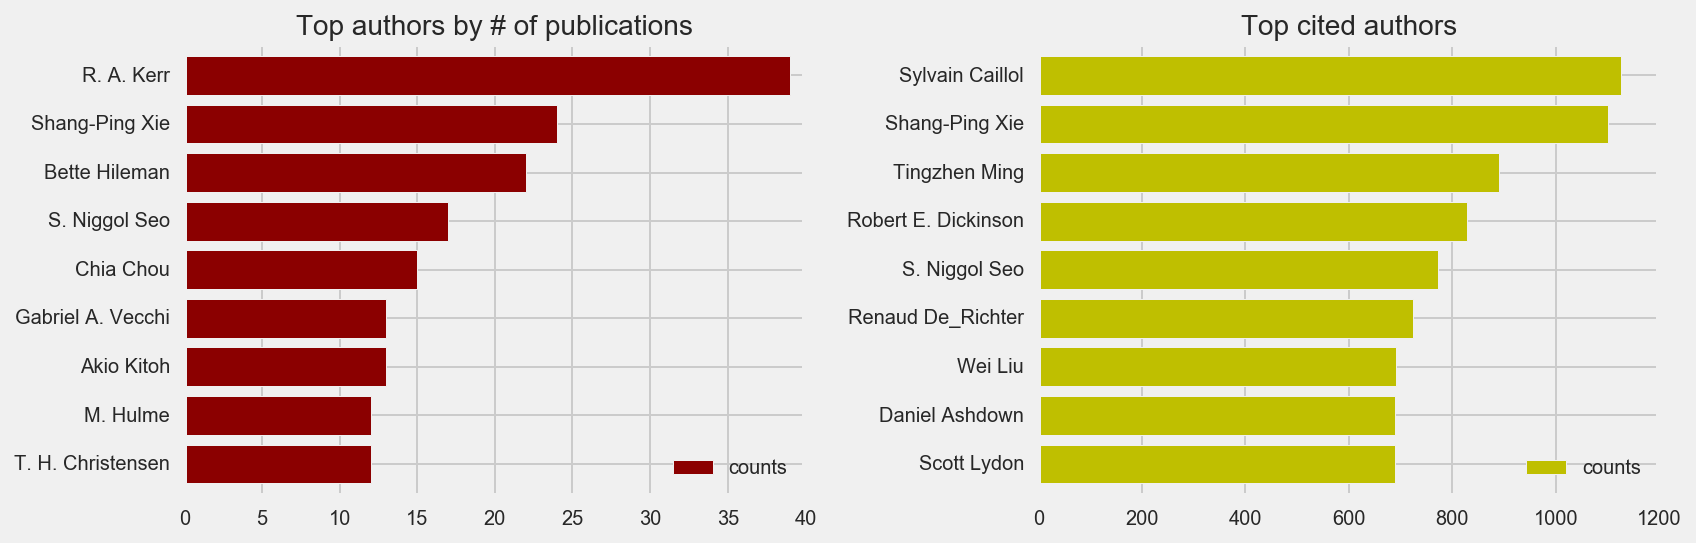


Running MCMC simulations to estimate the expected number of publications per year
 [-----------------100%-----------------] 50000 of 50000 complete in 20.4 sec

Searching for the best Time-Series ARIMA model to predict the future values ...


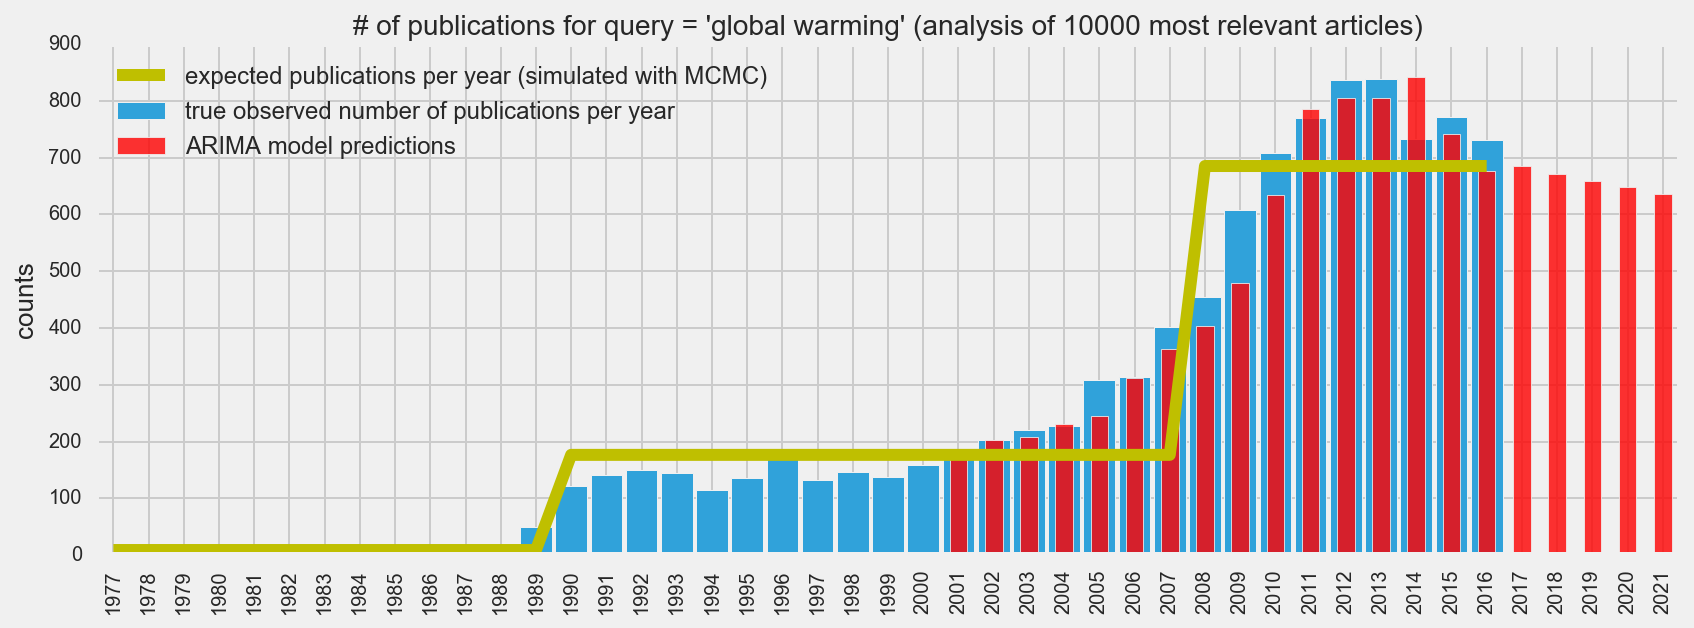


OCCURENCE OF TOP FREQUENT WORDS


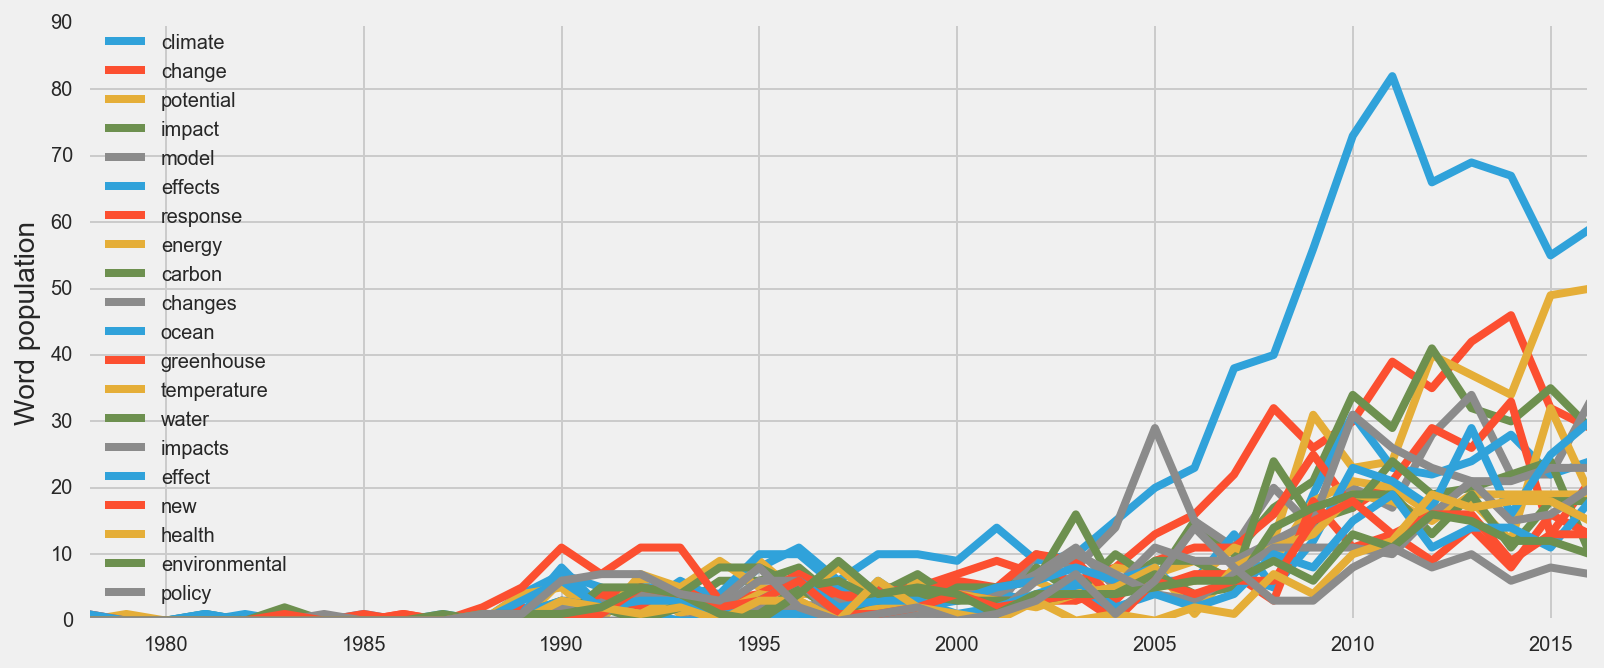


WORD CLOUD FOR YEARS BETWEEN 1966 and 1975


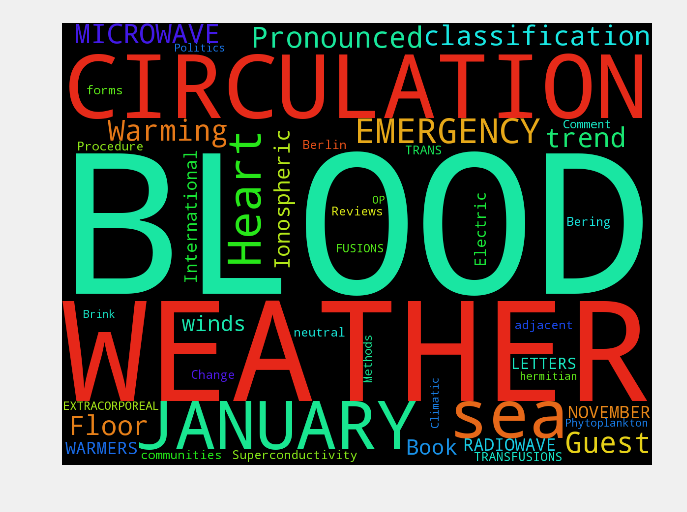


WORD CLOUD FOR YEARS BETWEEN 1986 and 1995


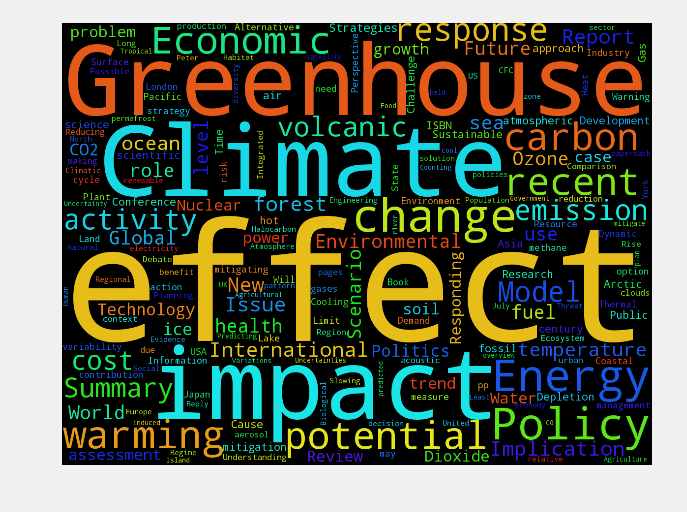


WORD CLOUD FOR YEARS BETWEEN 2006 and 2015


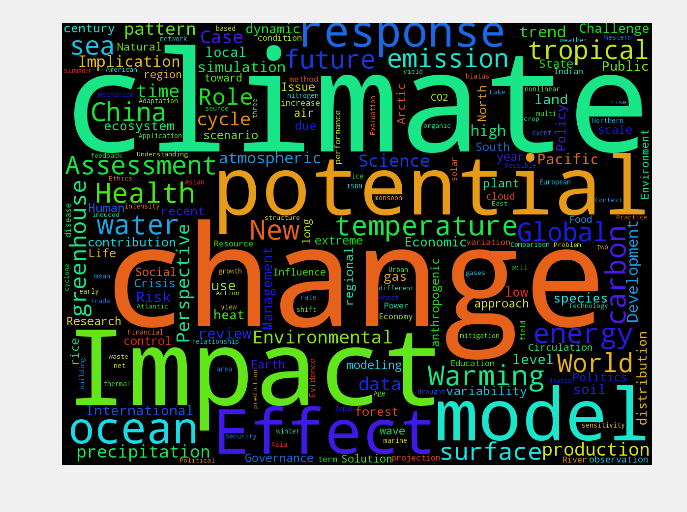


PROJECTING THE WORD CLOUD FOR THE NEXT 5 YEARS ...


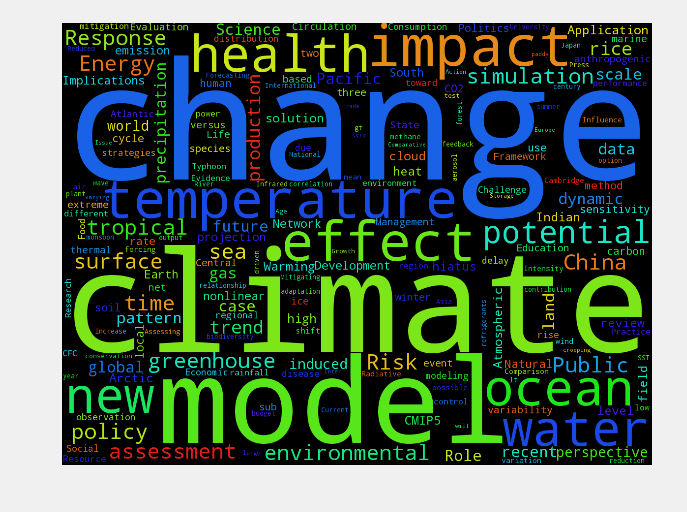

In [46]:
main()

## Case Studies: NEURAL NETWORK

YOUR QUERY: neural networks

Data mining in progress, acquiring:
                                   10000 of 10000 most relevant articles ... 
The analysis for your searh query was finished, a report will now be prepared


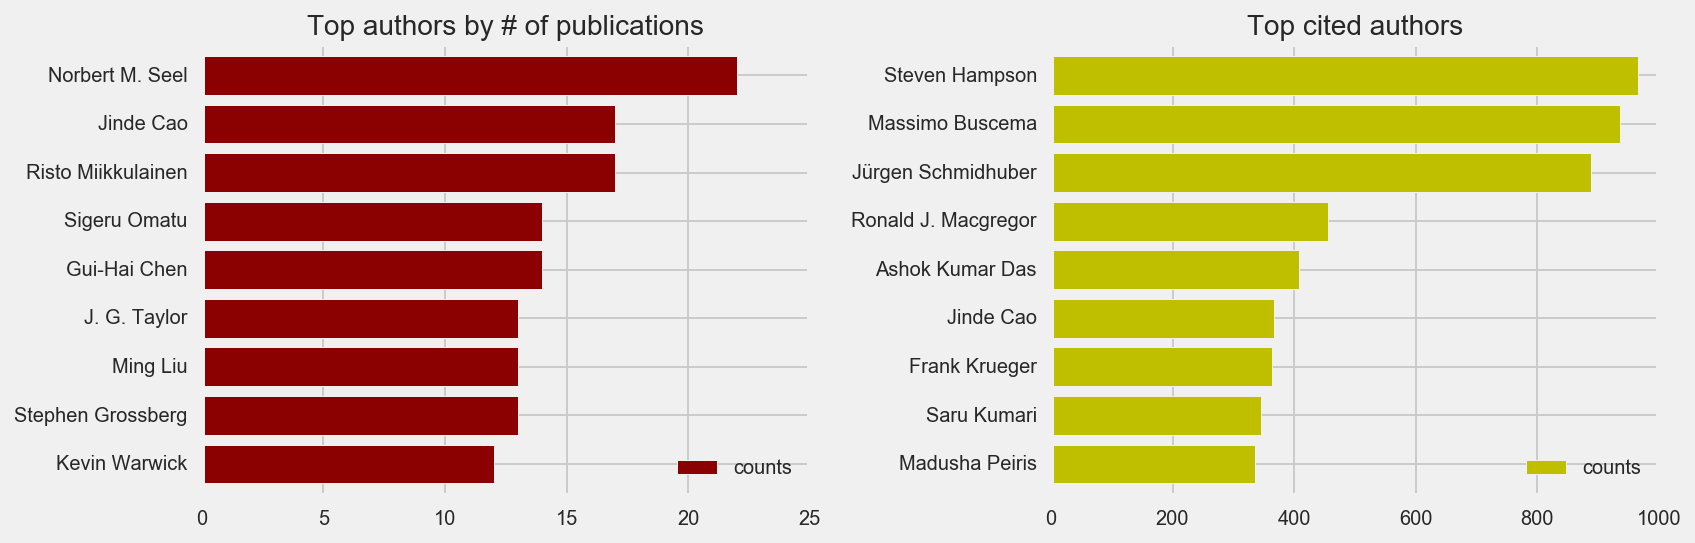


Running MCMC simulations to estimate the expected number of publications per year
 [-----------------100%-----------------] 50000 of 50000 complete in 23.6 sec

Searching for the best Time-Series ARIMA model to predict the future values ...


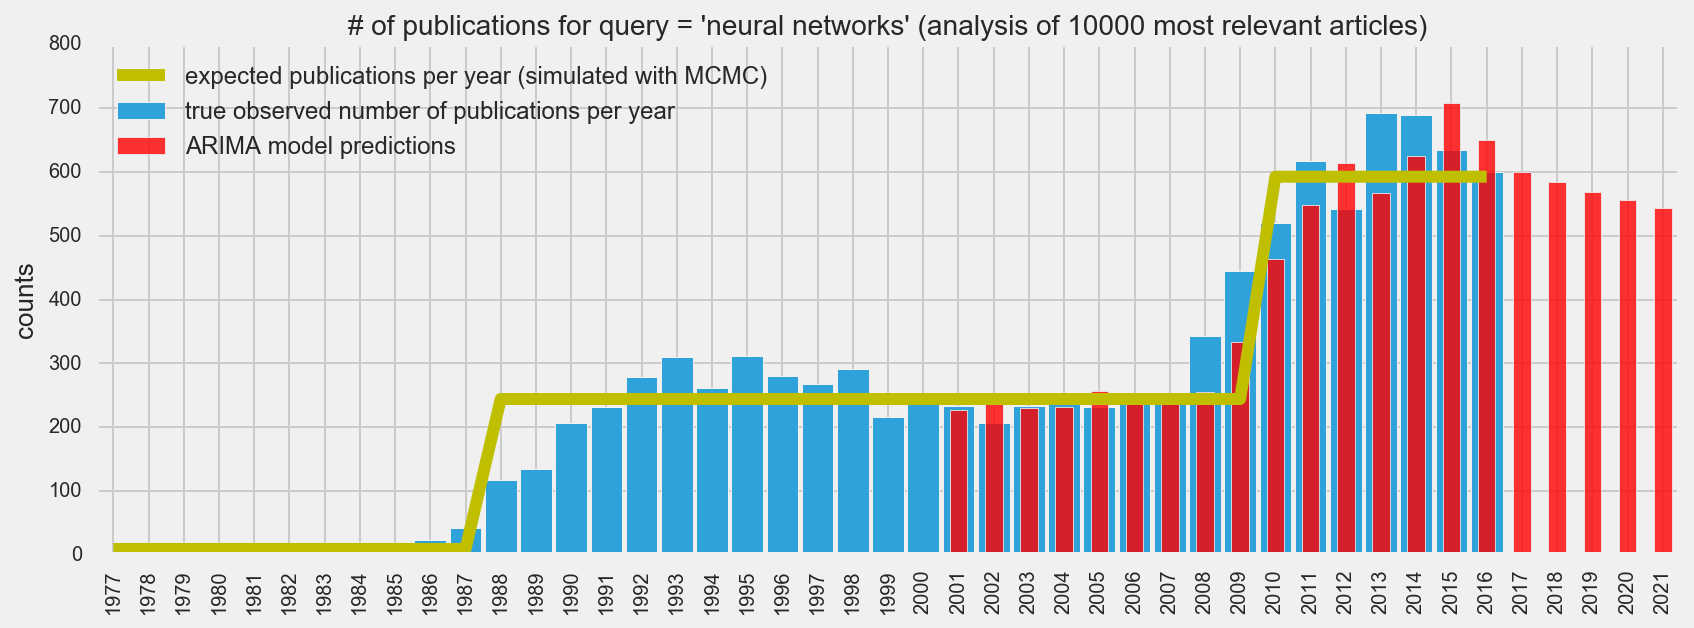


OCCURENCE OF TOP FREQUENT WORDS


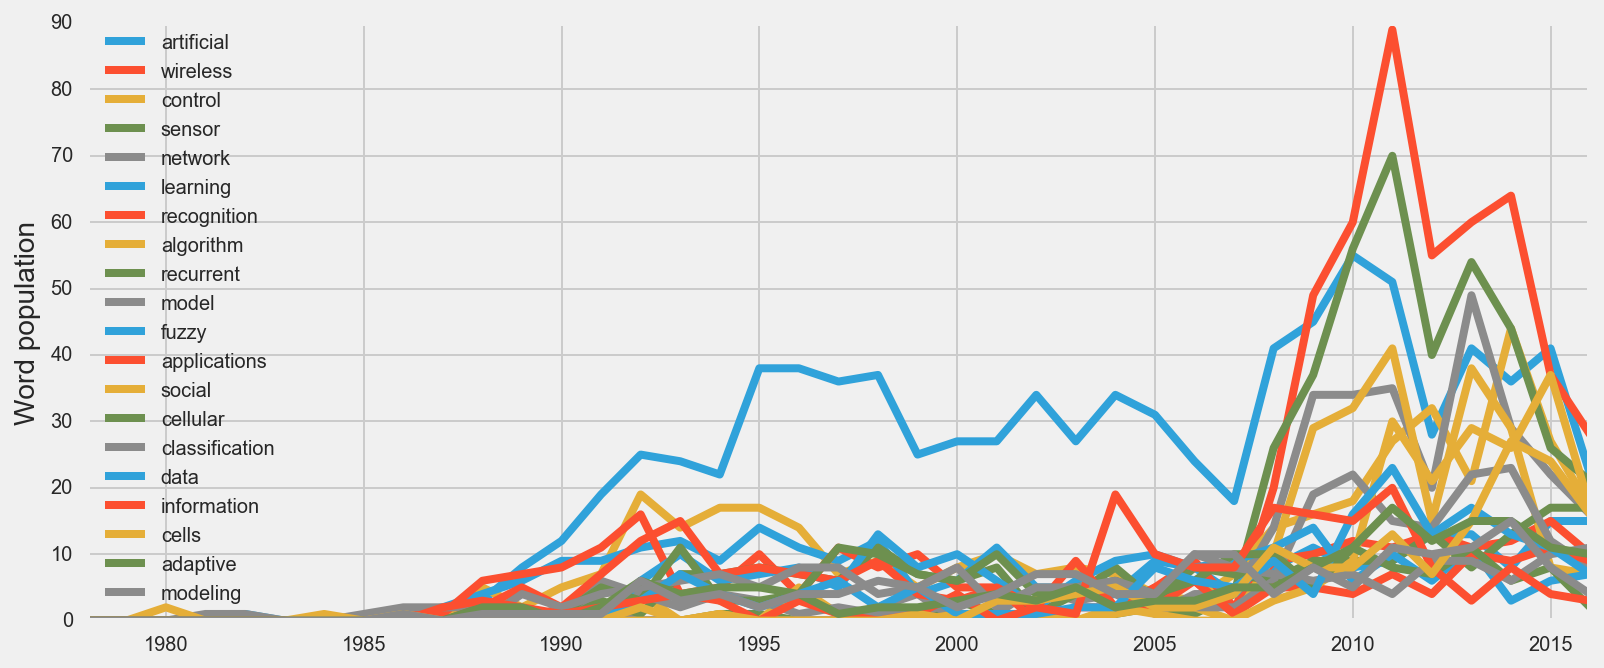


WORD CLOUD FOR YEARS BETWEEN 1966 and 1975


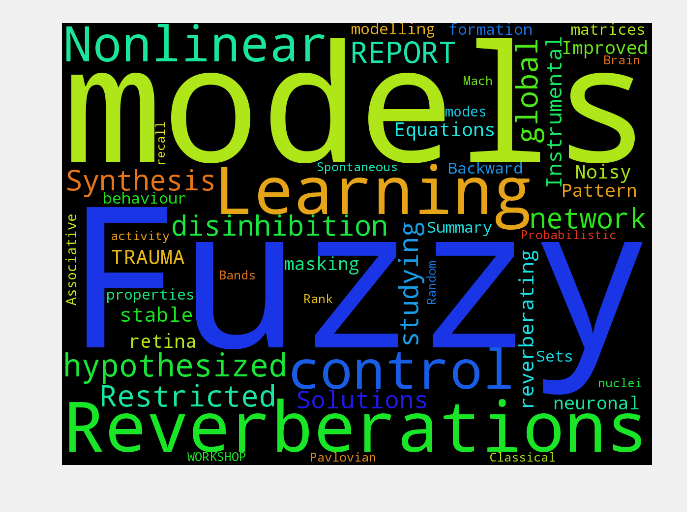


WORD CLOUD FOR YEARS BETWEEN 1986 and 1995


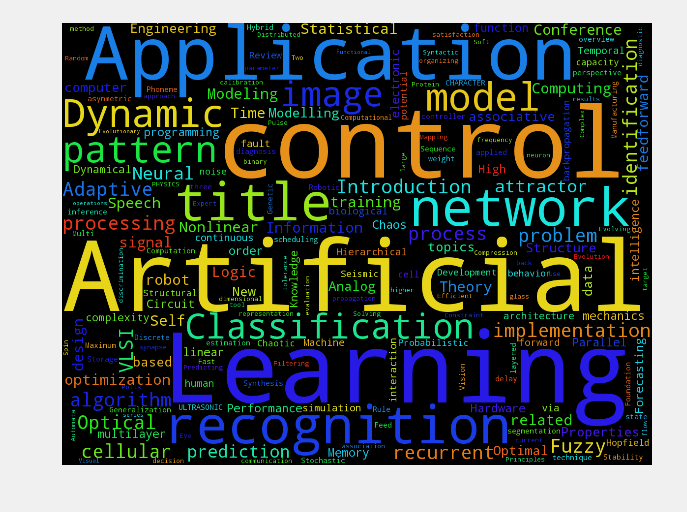


WORD CLOUD FOR YEARS BETWEEN 2006 and 2015


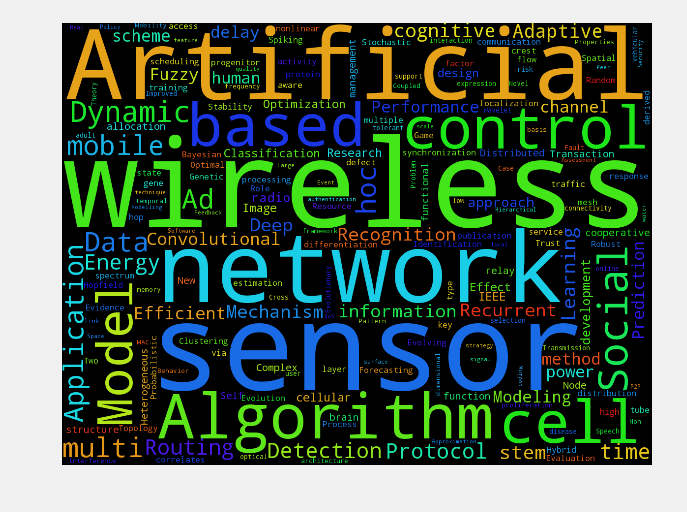


PROJECTING THE WORD CLOUD FOR THE NEXT 5 YEARS ...


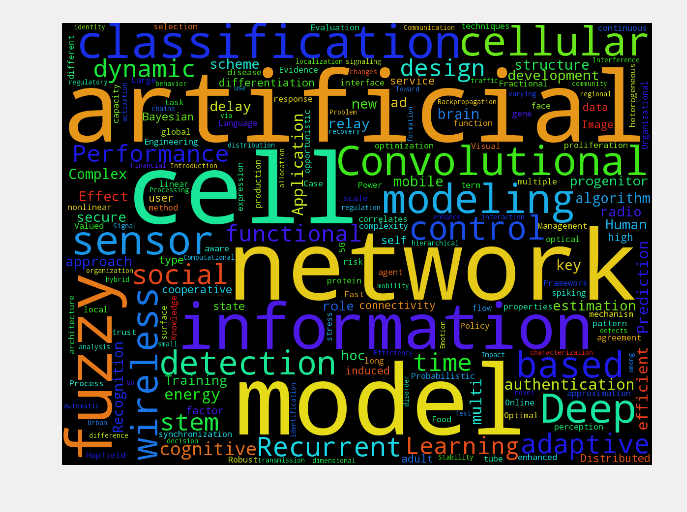

In [48]:
main()